[View in Colaboratory](https://colab.research.google.com/github/lyashevska/Complete-Python-Bootcamp/blob/master/Deep_Learning_in_Chainer.ipynb)

**To edit or run this Jupyter Notebook, go to `File` and `Make a Copy` to your own Google Drive and open with Colaboratory.**

![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer.png)


In [1]:
# Install Chainer and CuPy and NumPy
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 \
  /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80
!pip install chainer
import chainer as ch
import numpy as np
ch.config.debug = True  # Turn on debugging error messages

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 0s (56.8 MB/s)

78Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###..

In [2]:
print(ch.print_runtime_info())

Chainer: 4.4.0
NumPy: 1.14.5
CuPy:
  CuPy Version          : 4.4.0
  CUDA Root             : None
  CUDA Build Version    : 8000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 8000
  cuDNN Build Version   : 7102
  cuDNN Version         : 7102
  NCCL Build Version    : 2213
None


![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-dataset.png)



Shape of train (50000, 2)
Shape of x (784,)
Some raw x [0.8862746  0.83921576 0.8745099  0.97647065 0.7176471  0.75294125
 0.9725491  0.23529413 0.2509804  0.54509807 0.4901961  0.45098042
 0.16078432 0.2509804  0.53333336 0.94117653 0.7019608  0.61960787
 0.9294118  0.8980393 ]


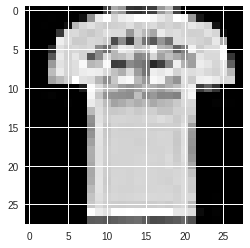

label: T-shirt/top


In [3]:
from chainer.datasets.fashion_mnist import get_fashion_mnist
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
          'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Download the MNIST data if you haven't downloaded it yet
train, test = get_fashion_mnist(withlabel=True, ndim=1)
train, valid = ch.datasets.split_dataset_random(train, 50000, seed=0)

# set matplotlib so that we can see our drawing inside this notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Display an example from the MNIST dataset.
# `x` contains the input image array and `t` contains that target class
# label as an integer.
x, t = train[0]

print('Shape of train', np.shape(train))

print('Shape of x', x.shape)

print('Some raw x', x[200:220])

plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', labels[t])

![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-iterator.png)

In [0]:
from chainer import iterators

# Choose the minibatch size.
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize,
                                     repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-model.png)

In [5]:
import chainer.functions as F
import chainer.links as L

def MLP():
  layer = ch.Sequential(L.Linear(100), F.relu)
  model = layer.repeat(3)
  model.append(L.Linear(10))
  
  return model

model = MLP()

# Check the network structure
print(model.flatten())

model_loss = L.Classifier(model)

gpu_id = -1  # change to 0 if using GPU

if gpu_id >= 0:
    model_loss.to_gpu(gpu_id)

0	Linear	W(None)	b(100,)	
1	relu
2	Linear	W(None)	b(100,)	
3	relu
4	Linear	W(None)	b(100,)	
5	relu
6	Linear	W(None)	b(10,)	



![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-optimizer.png)

In [0]:
# Choose an optimizer algorithm
optimizer = ch.optimizers.Adam().setup(model_loss)

![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-updater.png)

In [0]:
# Create the updater, using the optimizer
updater = ch.training.StandardUpdater(train_iter, optimizer, device=gpu_id)

![alt text](https://github.com/Crissman/chainer/raw/glance/docs/image/glance/trainer-extensions.png)

In [0]:
from chainer.training import extensions as E

# Set up a trainer
trainer = ch.training.Trainer(
    updater, (30, 'epoch'), out='result', extensions=[
        E.Evaluator(valid_iter, model_loss, device=gpu_id),
        E.dump_graph('main/loss'),
        E.LogReport(),
        E.PlotReport(['main/loss', 'validation/main/loss'],
                      'epoch', file_name='loss.png'),
        E.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                      'epoch', file_name='accuracy.png'),
        E.PrintReport(
              ['epoch', 'main/loss', 'validation/main/loss',
               'main/accuracy', 'validation/main/accuracy', 'elapsed_time'])])

**Note, to re-run the Trainer, the iterator definitions above must be re-run as well.**

In [9]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.598953    0.476671              0.790062       0.832476                  8.99063       
2           0.405908    0.398138              0.85462        0.857199                  19.1386       
3           0.360288    0.375182              0.869571       0.860957                  29.446        
4           0.336015    0.352059              0.877338       0.870945                  39.822        
5           0.314608    0.343255              0.883552       0.873813                  50.1623       
6           0.302326    0.339208              0.888001       0.875692                  60.428        
7           0.288036    0.34484               0.892463       0.873517                  70.8698       
8           0.273257    0.349087              0.898618       0.874407                  81.1463       
9           0.262822    0.331919              0.902354       0.878857               

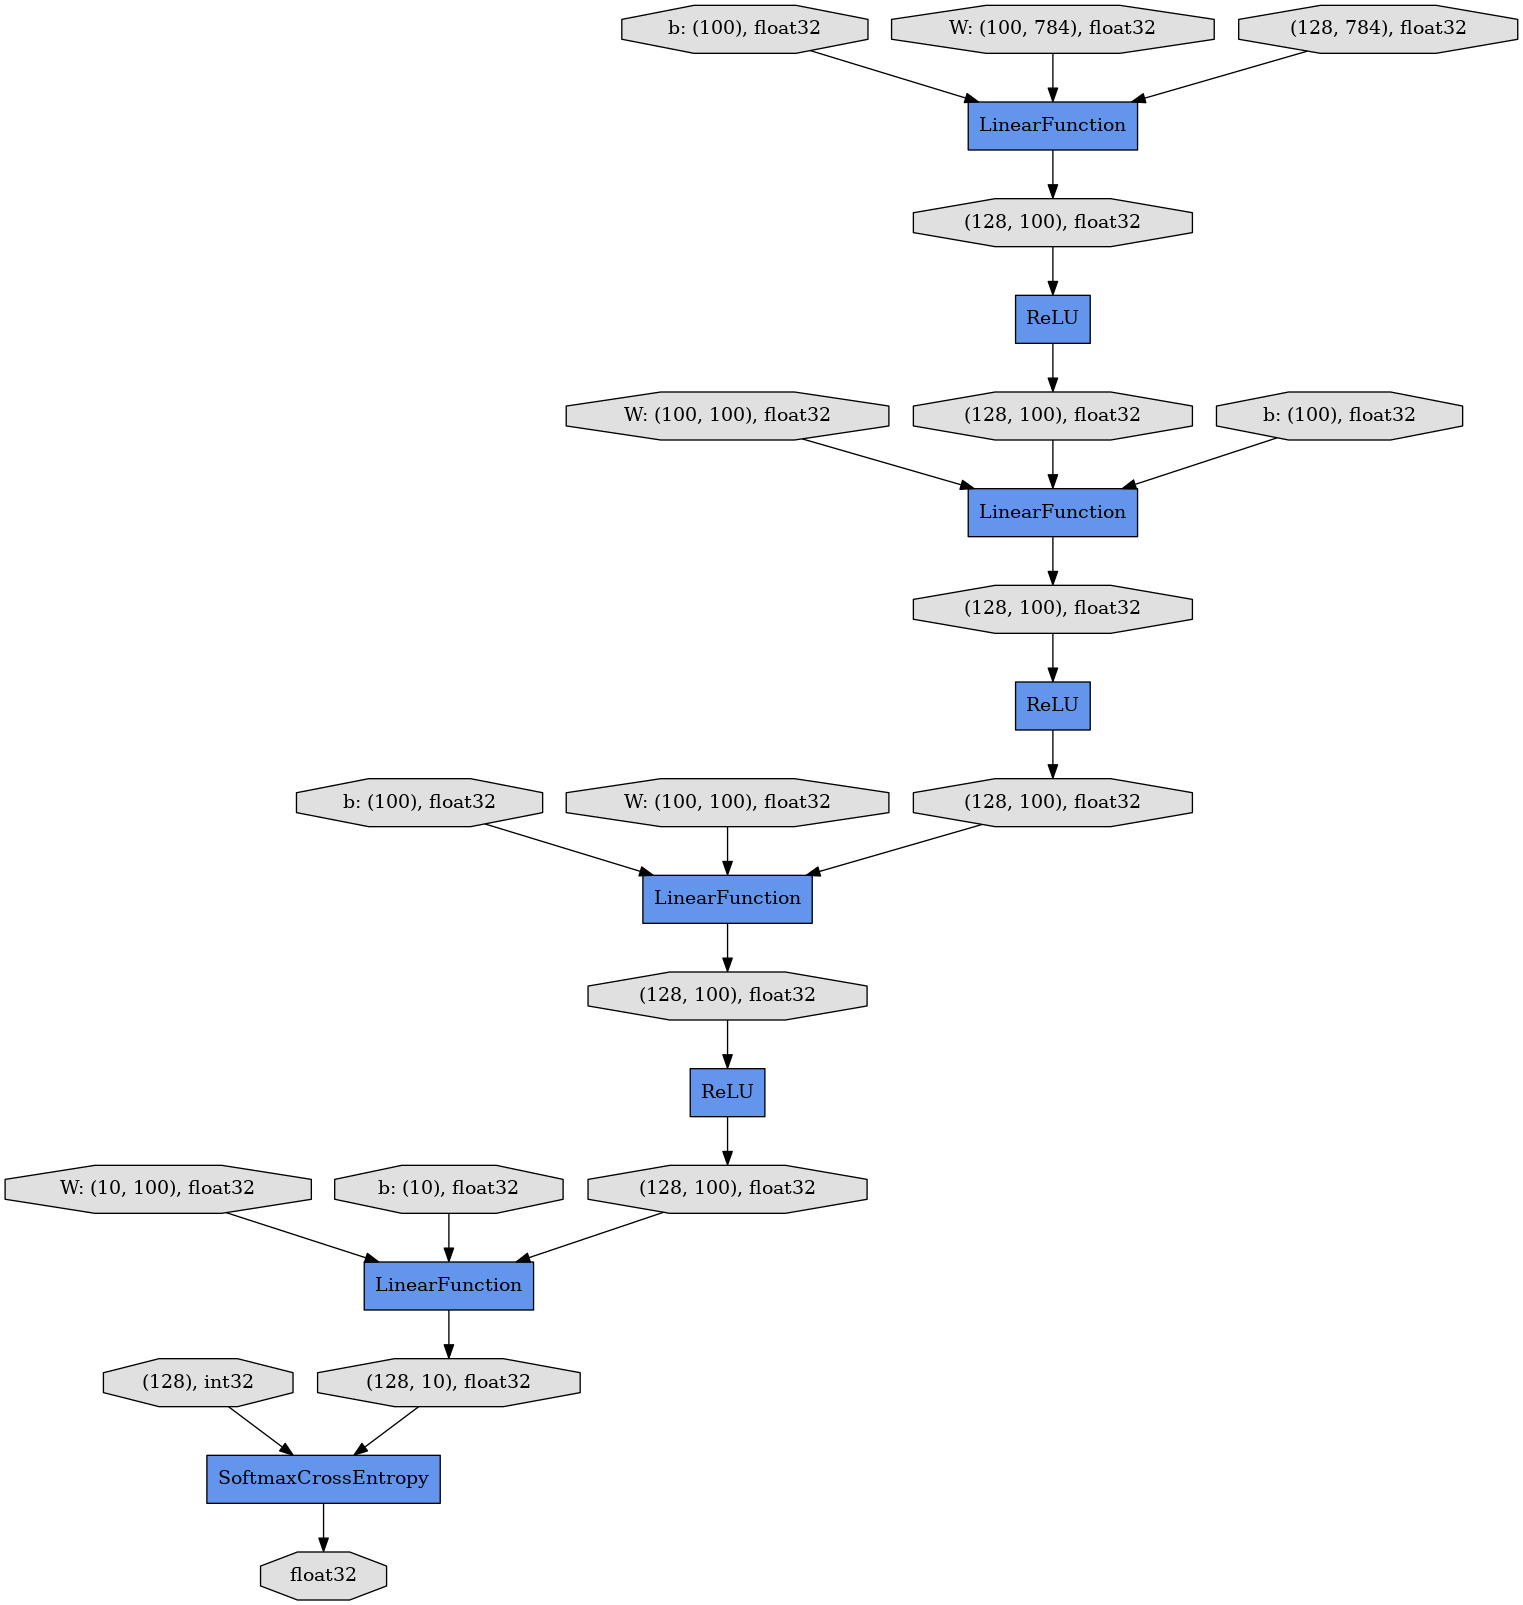

In [10]:
!apt-get -qq install -y graphviz > /dev/null
!dot -Tpng result/cg.dot -o result/cg.png

from IPython.display import Image
Image(filename='result/cg.png')

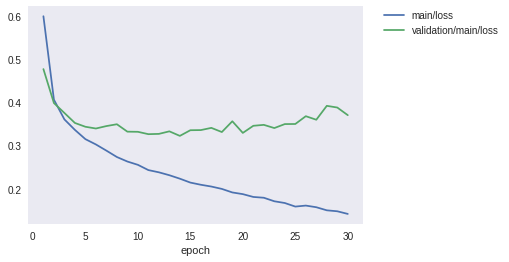

In [11]:
Image(filename='result/loss.png')


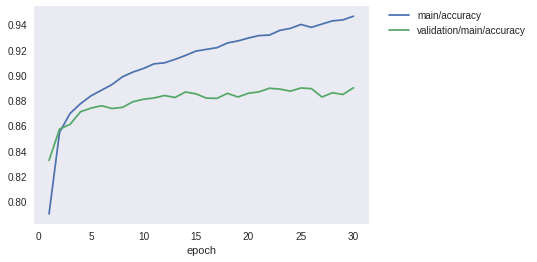

In [12]:
Image(filename='result/accuracy.png')

In [13]:
test_evaluator = E.Evaluator(test_iter, model_loss, device=gpu_id)
results = test_evaluator()

print('Test accuracy:', results['main/accuracy'])

Test accuracy: 0.8905261075949367


In [14]:
from chainer import serializers

serializers.save_npz('my_mnist.model', model)

# check if the model is saved.
%ls -la my_mnist.model

-rw-r--r-- 1 root root 372998 Aug 29 07:51 my_mnist.model


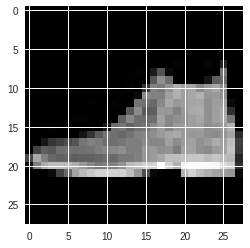

Ground truth: Ankle boot


In [15]:
# Create the inference (evaluation) model as the previous model
infer_model = MLP()

# Load the saved parameters into the inference model to overwrite 
serializers.load_npz('my_mnist.model', infer_model)

# Send the model to utilize GPU by to_GPU
if gpu_id >= 0:
    infer_model.to_gpu(gpu_id)
    
# Get a test image and label
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('Ground truth:', labels[t])

In [16]:
from chainer.cuda import to_gpu
from chainer.cuda import to_cpu

# change the shape to minibatch. 
# In this example, the size of minibatch is 1. 
# Inference using any mini-batch size can be performed.

print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

# to calculate by GPU, send the data to GPU, too. 
if gpu_id >= 0:
    x = to_gpu(x, 0)

# forward calculation of the model by sending X
with ch.using_config('train', False):
  y = infer_model(x)

# The result is a Variable. Look at the contents by the attribute: .data. 
y = y.data

# send the gpu result to cpu
y = to_cpu(y)

print('Label values: ', np.around(y, decimals=1))

# The most probable number by looking at the argmax
pred_label = y.argmax(axis=1)

print('Predicted label:', labels[pred_label[0]])

(784,) -> (1, 784)
Label values:  [[-11.8 -11.5 -14.9  -5.  -17.3  -4.1 -16.4   2.3 -12.7   9.7]]
Predicted label: Ankle boot
